# Dreambooth fine-tuning for Stable Diffusion

In this notebook, we'll try to use [Dreambooth](https://huggingface.co/docs/diffusers/training/dreambooth) to generate images of military vehicles for training our vehicle detection model. Our model suffers from a lack of diversity in its training data available, so we'll see if we can improve our training dataset with synthetic images generated by a text-to-image model. [Dreambooth](https://arxiv.org/abs/2208.12242) is a method to personnalize text-to-image models with just a few images of a subject.

We use the training script provided by diffusers [here](https://github.com/huggingface/diffusers/tree/main/examples/dreambooth) and follow the guide available [here](https://huggingface.co/docs/diffusers/training/dreambooth).

## Configuration
As explained in the guide, dreambooth is quite susceptible to overfitting and finding the right hyperparameters can be challenging. We tried various configurations to find the one that works best for our use case. We also followed the advice from [their analysis](https://huggingface.co/blog/dreambooth) on how to train dreambooth.

Overall, we found that using Low-Rank Adaptation of Large Language Models (LoRA) gives better results, or at least is easier to train and finetune. We also took advantage of GPU optimization tools, such as [xFormers](https://github.com/facebookresearch/xformers) (enabled by adding the `--enable_xformers_memory_efficient_attention` argument to the training script) and [bitsandbytes](https://github.com/TimDettmers/bitsandbytes) 8-bit optimizer (add `--use_8bit_adam`).

## Setup

Before running the script, we need to install the dependencies. Installing the dependencies with poetry caused some issues, so we recommend to use a python virtual env manager to install dependencies.

In [1]:
# Clone the huggingface diffusers repo and install dependencies
!git clone https://github.com/huggingface/diffusers ../diffusers
!pip install -e ../diffusers
!pip install -U -r ../diffusers/examples/dreambooth/requirements_sdxl.txt
!pip install bitsandbytes xformers matplotlib
!accelerate config default

Clonage dans '../diffusers'...
remote: Enumerating objects: 65921, done.
remote: Counting objects: 100% (15655/15655), done.
remote: Compressing objects: 100% (1802/1802), done.
remote: Total 65921 (delta 14813), reused 14007 (delta 13789), pack-reused 50266
Réception d'objets: 100% (65921/65921), 46.08 Mio | 10.95 Mio/s, fait.
Résolution des deltas: 100% (48952/48952), fait.
Obtaining file:///home/ukemkata/workspace/adomvi2/diffusers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for diffusers (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.30.0.dev0-0.editable-py3-none-any.whl size=11116 sha256=26ccb1b2c95a7f6fd477e25010c46f289435eb0166e590a2f3c15d3e5a91bb4d
  Stored in directory: /tmp/pip-ephem-wheel-cache-lc9n0l_a/wheels/8c/d4/44/18b7e7bb35338d55d70e5ef344b6f248e03157d839283

After installing the dependencies for the first time, we need to restart the kernel before running other cells.
We can update dependencies with Poetry:

In [7]:
!poetry update

<IPython.core.display.Javascript object>

## Fine-tune the model

To train the model, we found these settings work best: we train with LoRA, on 800 steps, saving checkpoints every 250 step. We finetune the text_encoder along with the unet. The following script will also train dreambooth with prior-preservation by generating 100 images of tank. However, the images generated with Stable Diffusion often have undesirable artifacts and it would probably be better to use our own class dataset.

#### Instance data

To train dreambooth, you need to provide a limited sample of a specific subject instance that dreambooth will learn. In this notebook, we'll try to use dreambooth to generate images of a specific type of tank, the [Leclerc Tank](https://en.wikipedia.org/wiki/Leclerc_tank). We created a dataset of 15 images of the Leclerc Tank to finetune dreambooth on by using our [GoogleImageScraper](./scraper/google.py). You can generate your own dataset or use the one we added to the [resources dir](../resources/leclerc).

#### Prior preservation

Prior preservation is used to avoid overfitting and language-drift (see the [dreambooth paper](https://arxiv.org/abs/2208.12242)). For prior preservation, we need other images of the same class (military vehicles). We have two options: we can use some of the tank images that we gathered from open-source image datasets (see the [TankDetectionYoloV8Train notebook](./TankDetectionYolov8Train.ipynb), or we can use Stable Diffusion to generate thoses images itself. Either case works fine, however the images generated with Stable Diffusion often have undesirable artifacts (multiple canons, etc.) which could probably be avoided by using a proper curated dataset.

To sample 200 tank images from our `military-vehicles` dataset, run the following script. Otherwise, if the `tanks` directory is empty, Stable Diffusion will generate the missing tank images.

In [3]:
import fiftyone as fo
from pathlib import Path
from fiftyone import ViewField as F 


# Load the train split of the dataset, keeping only 400 images of AFV
dataset_dir = Path() / "dataset"
dataset = fo.Dataset()
dataset.add_dir(
    dataset_dir=dataset_dir,
    dataset_type=fo.types.YOLOv5Dataset,
    split="train",
    tags="train",
)
dataset = dataset.filter_labels("ground_truth", F("label") == "AFV").take(400)
# Export these 400 images to the tank directory
export_dir = "../tanks"
dataset.export(export_dir=export_dir, dataset_type=fo.types.ImageDirectory)

 100% |███████████████| 5336/5336 [4.4s elapsed, 0s remaining, 1.2K samples/s]      
 100% |█████████████████| 400/400 [375.0ms elapsed, 0s remaining, 1.1K samples/s]       


To train the model, we found these settings work best: we train with LoRA, on 800 steps, saving checkpoints every 250 step. We finetune the text_encoder along with the unet. We use prior-preservation with 400 samples of tank images.

In [4]:
!accelerate launch ../diffusers/examples/dreambooth/train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --train_text_encoder \
  --instance_data_dir="../resources/leclerc" \
  --class_data_dir="../tanks" \
  --output_dir="../adomvi-dream-tank" \
  --mixed_precision="fp16" \
  --with_prior_preservation \
  --prior_loss_weight=1.0 \
  --instance_prompt="a photo of [L] tank" \
  --class_prompt="a photo of a tank" \
  --num_class_images=400 \
  --resolution=1024 \
  --train_batch_size=1 \
  --use_8bit_adam \
  --enable_xformers_memory_efficient_attention \
  --gradient_accumulation_steps=4 \
  --checkpointing_steps=250 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --max_train_steps=800 \
  --validation_prompt="A photo of [L] tank on the moon" \
  --validation_epochs=50 \
  --seed="0"

07/22/2024 17:39:36 - INFO - __main__ - Distributed environment: MULTI_GPU  Backend: nccl
Num processes: 2
Process index: 0
Local process index: 0
Device: cuda:0

Mixed precision type: fp16

07/22/2024 17:39:36 - INFO - __main__ - Distributed environment: MULTI_GPU  Backend: nccl
Num processes: 2
Process index: 1
Local process index: 1
Device: cuda:1

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'rescale_betas_zero_snr', 'clip_sample_range', 'thresholding', 'dynamic_thresholding_ratio', 'variance_type'} was not found in config. Values will be initialized to default values.
{'shift_factor', 'latents_std', 'latents_mean', 'use_post_quant_conv', 'use_quant_conv'} was not found in config. Values wil

## Running inference

#### Downloading our sample model weights

Finetuning a model with dreambooth requires a GPU with a lot of memory. If this is unavailable to you, you can download the model weights from on our training run [here](https://github.com/jonasrenault/adomvi/releases/download/v1.1.0/adomvi-dream-tank.tar.gz). Unzip the weights in a directory called `adomvi-dream-tank` at the root of the project.

#### Generating images from text prompts

Once our model is trained, we can run inference to generate new images of a leclerc tank. Since our original military vehicle dataset lacks images taken from a distance, or where the subject is partially hidden, we try to generate such images by constructing a complex prompt.

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLPipeline and will be ignored.
100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


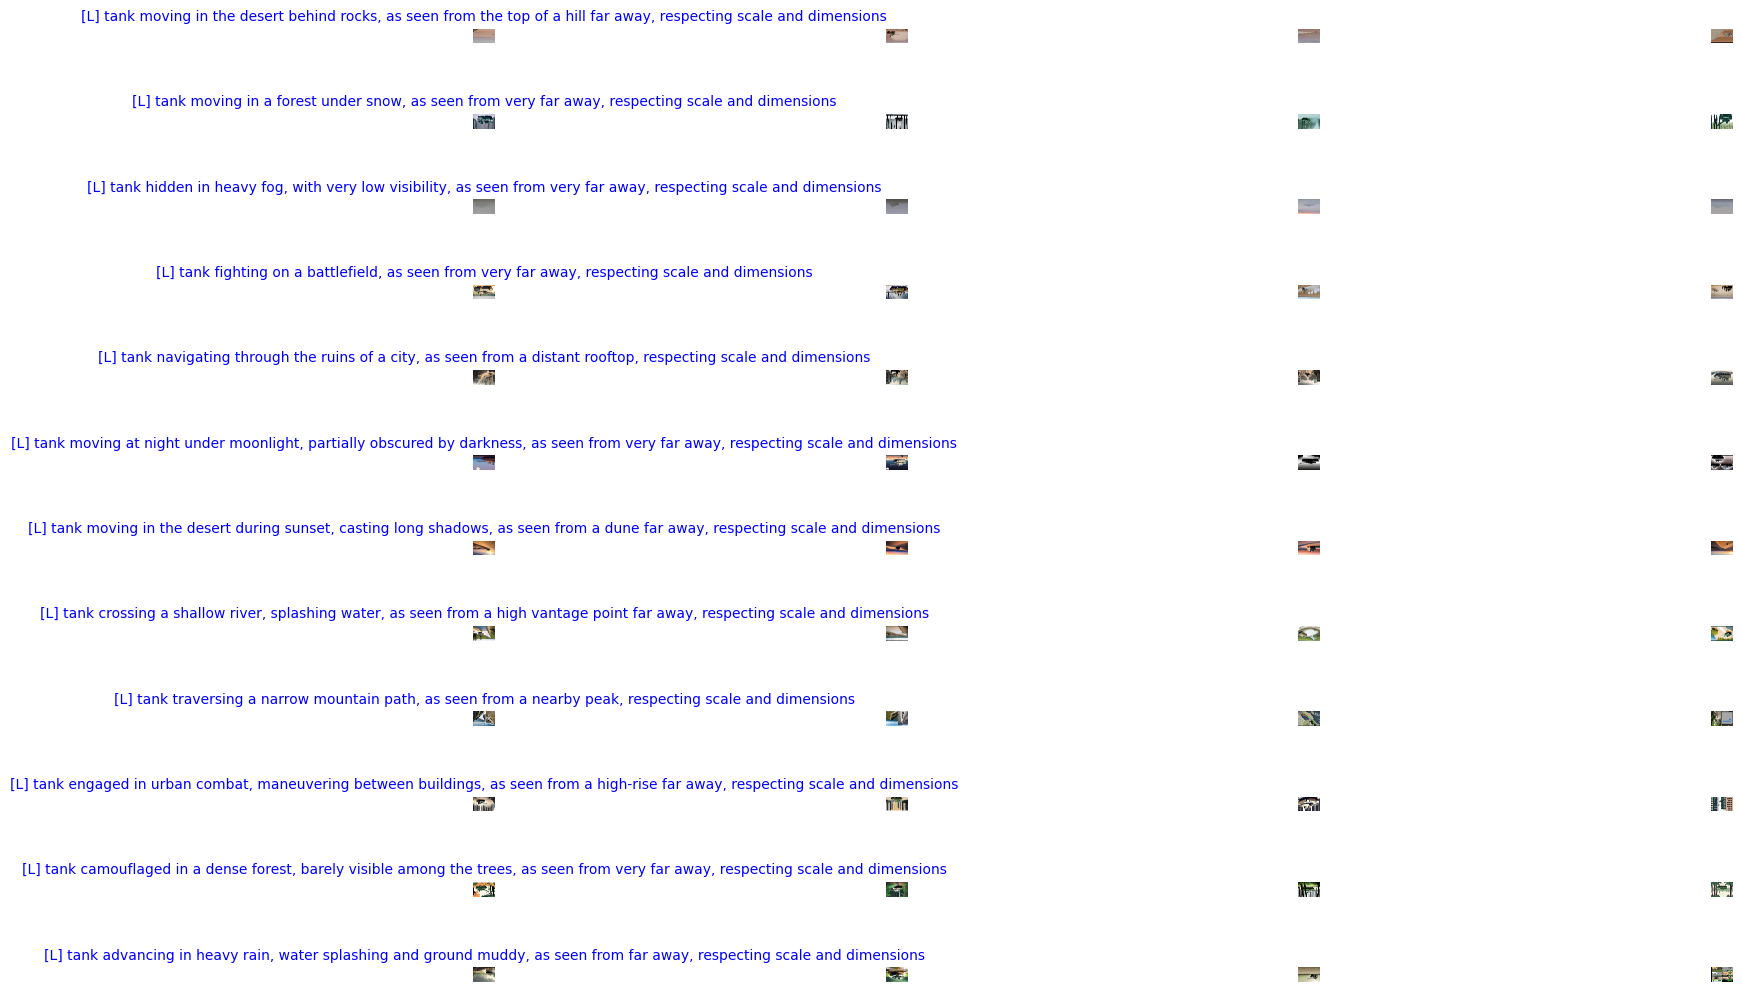

In [3]:
from adomvi.datasets.diffusers import generate_images
from pathlib import Path

inference_dir = Path() / "../inference_XL"

lora_model_id = "../adomvi-dream-tank"
model_base = "stabilityai/stable-diffusion-xl-base-1.0"

prompts = {
    "desert": "[L] tank moving in the desert behind rocks, as seen from the top of a hill far away, respecting scale and dimensions",
    "snow": "[L] tank moving in a forest under snow, as seen from very far away, respecting scale and dimensions",
    "fog": "[L] tank hidden in heavy fog, with very low visibility, as seen from very far away, respecting scale and dimensions",
    "battle": "[L] tank fighting on a battlefield, as seen from very far away, respecting scale and dimensions",
    "city_ruins": "[L] tank navigating through the ruins of a city, as seen from a distant rooftop, respecting scale and dimensions",
    "night_operation": "[L] tank moving at night under moonlight, partially obscured by darkness, as seen from very far away, respecting scale and dimensions",
    "desert_sunset": "[L] tank moving in the desert during sunset, casting long shadows, as seen from a dune far away, respecting scale and dimensions",
    "river_crossing": "[L] tank crossing a shallow river, splashing water, as seen from a high vantage point far away, respecting scale and dimensions",
    "mountain_path": "[L] tank traversing a narrow mountain path, as seen from a nearby peak, respecting scale and dimensions",
    "urban_combat": "[L] tank engaged in urban combat, maneuvering between buildings, as seen from a high-rise far away, respecting scale and dimensions",
    "forest_camouflage": "[L] tank camouflaged in a dense forest, barely visible among the trees, as seen from very far away, respecting scale and dimensions",
    "rainy_day": "[L] tank advancing in heavy rain, water splashing and ground muddy, as seen from far away, respecting scale and dimensions"
}

negative_prompt = "close-up, upfront, unobstructed, bad scale, (inaccurate canons:1.2), extra canons"

generate_images(
    lora_model_id=lora_model_id,
    model_base=model_base,
    prompts=prompts,
    negative_prompt=negative_prompt,
    inference_dir=inference_dir
)